In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import random
from scipy.stats import norm, uniform, chi2

import arviz as az

In [2]:
dat = pd.read_csv('Data/Howell1.csv', sep=';')

# We are interested in adult's height
dat_adults = dat[dat['age'] >= 18].reset_index(drop=True)

## Construction and fit of a Bayesian probability model

### How to determine a reasonable prior distribution?

The **prior predictive** is an essential part of our modeling. **By simulating from this distribution, we can see what our choices imply about observable height**. This helps us diagnose bad choices. Lots of conventional choices are indeed bad ones, and we'll be able to see this through prior predictive simulations.

A reasonable prior

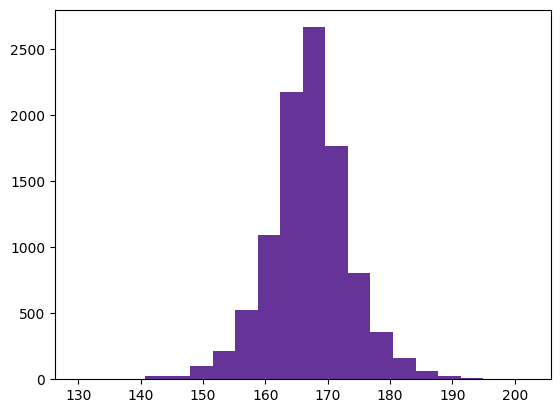

In [3]:
n_prior          = 10**4

sample_mu        = norm.rvs(size=n_prior, loc=167, scale=3)
sample_sigma     = uniform.rvs(size=n_prior, loc=0, scale=10)
prior_predictive = norm.rvs(size=n_prior, loc=sample_mu, scale=sample_sigma)

_ = plt.hist(prior_predictive, color='rebeccapurple', bins=20)

An unreasonable prior

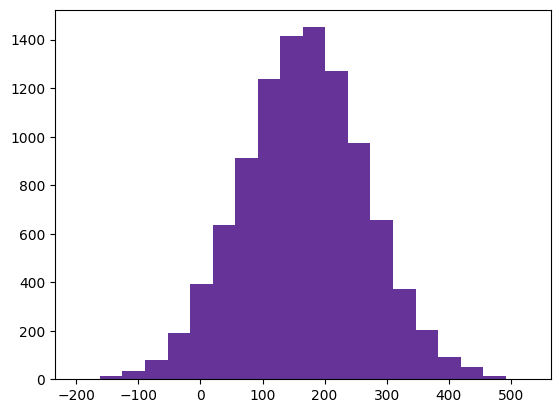

In [4]:
sample_mu        = norm.rvs(size=n_prior, loc=167, scale=100)
sample_sigma     = uniform.rvs(size=n_prior, loc=0, scale=10)
prior_predictive = norm.rvs(size=n_prior, loc=sample_mu, scale=sample_sigma)

_ = plt.hist(prior_predictive, color='rebeccapurple', bins=20)

Return to the reasonable prior

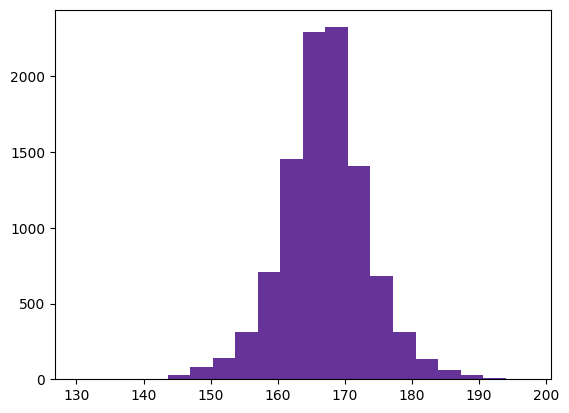

In [5]:
sample_mu        = norm.rvs(size=n_prior, loc=167, scale=3)
sample_sigma     = uniform.rvs(size=n_prior, loc=0, scale=10)
prior_predictive = norm.rvs(size=n_prior, loc=sample_mu, scale=sample_sigma)

_ = plt.hist(prior_predictive, color='rebeccapurple', bins=20)

## We use the grid technique to approximate the posterior

In [4]:
mu_list             = np.linspace(153.75, 155.75, 100)
sigma_list          = np.linspace(7, 8.5, 100)
mu_grid, sigma_grid = np.meshgrid(mu_list, sigma_list)

In [5]:
loglike = []

for i in range(len(mu_grid.ravel())):
    loglike.append(norm.logpdf(dat_adults['height'], mu_grid.ravel()[i], sigma_grid.ravel()[i]).sum())
    
loglike = np.array(loglike).reshape(mu_grid.shape)

logpost = loglike + norm.logpdf(mu_grid, 167, 3) + uniform.logpdf(sigma_grid, loc=0, scale=10)

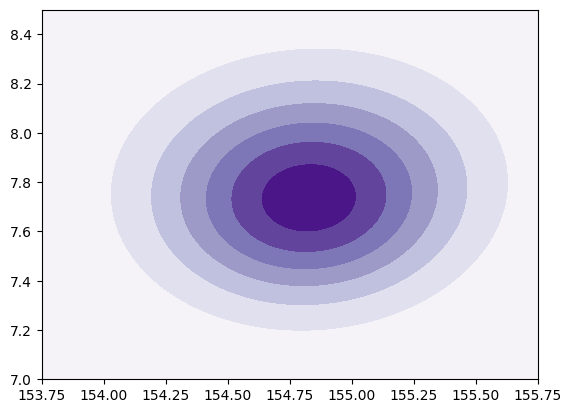

In [6]:
plt.contourf(mu_grid, sigma_grid, np.exp(logpost - logpost.max()), cmap='Purples')

We can use the normal approximation to get a region of posterior probability of $(1-\alpha)\times 100\%$.

/tmp/ipykernel_6589/2087600621.py:3: UserWarning: The following kwargs were not used by contour: 'color'
  plt.contour(


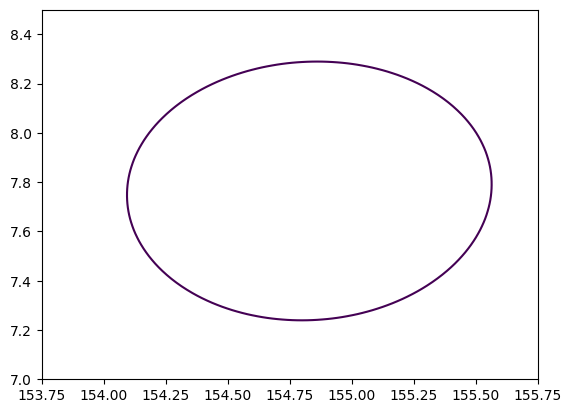

In [9]:
alpha = 0.2

plt.contour(
    mu_grid
    , sigma_grid
    , np.exp(logpost - logpost.max())
    #, cmap='Purples'
    , levels=[
        np.exp(-0.5 * chi2.ppf(1-alpha, 2))
        ]
    , color='rebeccapurple'
    )

Generate a sample from the posterior

In [10]:
n_posterior = 10**4

candidates = pd.DataFrame(np.c_[mu_grid.ravel(), sigma_grid.ravel()], columns=['mu', 'sigma'])
sample_ind = random.choices(range(candidates.shape[0]), weights=np.exp(logpost - logpost.max()).ravel(), k=n_posterior)
posterior_sample = candidates.iloc[sample_ind]
posterior_sample = posterior_sample.reset_index(drop=True)

<Axes: xlabel='mu', ylabel='sigma'>

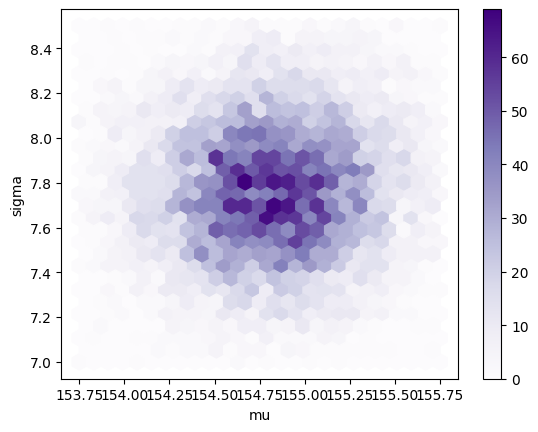

In [11]:
posterior_sample.plot.hexbin(x='mu', y='sigma', cmap='Purples', gridsize=25)

<Axes: xlabel='mu', ylabel='sigma'>

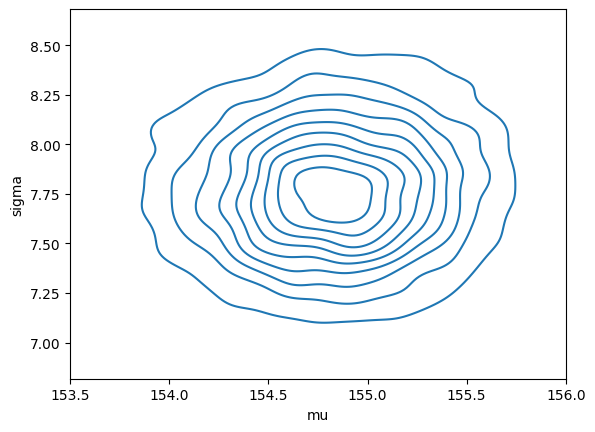

In [12]:
sns.kdeplot(data=posterior_sample, x='mu', y='sigma')

In [13]:
posterior_sample.describe()

,mu,sigma
count,10000.000000,10000.000000
mean,154.820295,7.767968
std,0.388798,0.282179
min,153.750000,7.000000
25%,154.558081,7.575758
50%,154.820707,7.757576
75%,155.103535,7.954545
max,155.750000,8.500000


In [14]:
az.hdi(posterior_sample.to_numpy(), hdi_prob=0.5)

/tmp/ipykernel_6589/1197683196.py:1: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  az.hdi(posterior_sample.to_numpy(), hdi_prob=0.5)


array([[154.51767677, 155.04292929],
       [  7.53030303,   7.90909091]])

## Model Checking

Once we have accomplished the first two steps of a Bayesian analysis—constructing a probability model and computing the posterior distribution of all estimands—we should not ignore the relatively easy step of assessing the fit of the model to the data and to our
substantive knowledge. It is difficult to include in a probability distribution all of one’s knowledge about a problem, and so it is wise to investigate what aspects of reality are *not* captured by the model.

A good Bayesian analysis, therefore, should include at least some check of the adequacy of the fit of the model to the data and the **plausibility of the model for the purposes for which the model will be used**. We do not like to ask, ‘Is our model true or false?’, The more relevant question is, **‘Do the model’s deficiencies have a noticeable effect on the substantive inferences?’**

If the model fits, then replicated data generated under the model should look similar to observed data. To put it another way, the observed data should look plausible under the posterior predictive distribution. Our basic technique for checking the fit of a model to data is to draw simulated values from the joint posterior predictive distribution of replicated data and compare these samples to the observed data.

In [15]:
posterior_sample

,mu,sigma
0,155.022727,7.409091
1,154.780303,8.166667
2,154.719697,7.863636
3,154.800505,7.863636
4,154.335859,7.393939
...,...,...
9995,154.396465,8.303030
9996,154.477273,7.393939
9997,155.103535,7.333333
9998,154.214646,8.227273


In [16]:
posterior_predictive_samples = []

for i in range(n_posterior):
     posterior_predictive_samples.append(
        norm.rvs(
            size=len(dat_adults)
            , loc=posterior_sample.iloc[i]['mu']
            , scale=posterior_sample.iloc[i]['sigma'])
        )

posterior_predictive_samples = np.array(posterior_predictive_samples)

In [17]:
posterior_predictive_samples.shape

(10000, 352)

In [19]:
dat_adults = dat_adults.reset_index(drop=True)

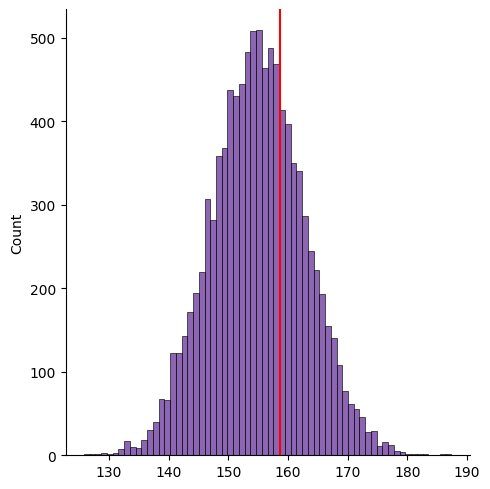

In [32]:
sns.displot(posterior_predictive_samples[:,351], color='rebeccapurple')
plt.axvline(dat_adults.iloc[351]['height'], color='r')

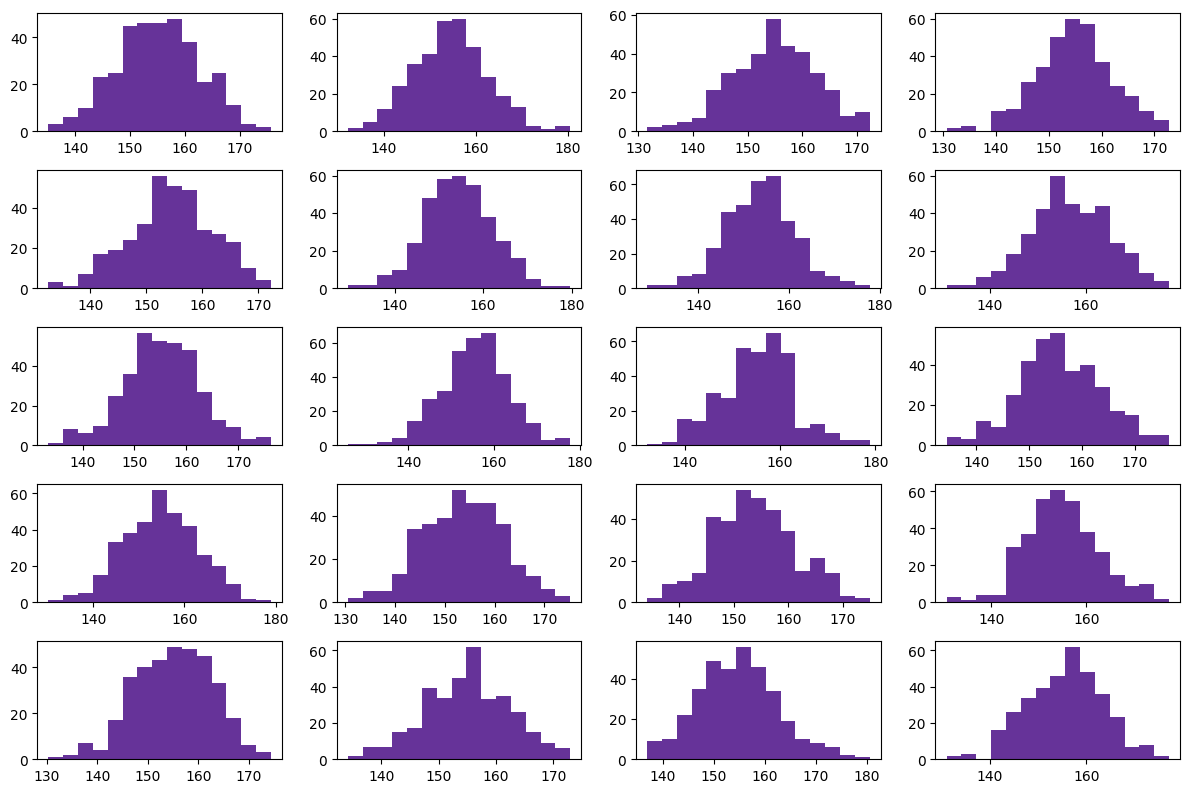

In [30]:
fig, axs = plt.subplots(figsize=(12, 8), ncols=4, nrows=5)

ind = 0
for j in range(5):
    for k in range(4):
        axs[j, k].hist(posterior_predictive_samples[ind], bins=15, color='rebeccapurple')
        ind = ind + 1
        
fig.tight_layout()

Text(0.5, 1.0, 'Distribution of the measurements')

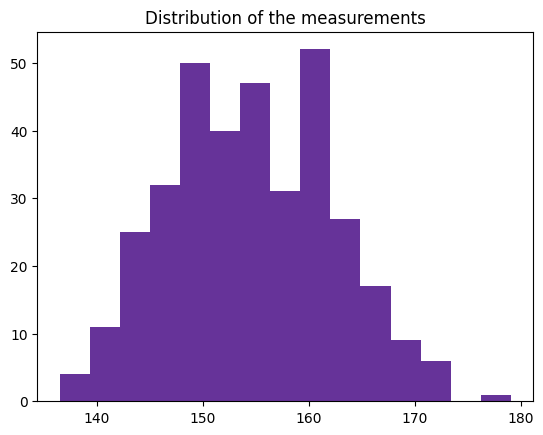

In [31]:
plt.hist(dat_adults['height'], bins=15, color='rebeccapurple')
plt.title('Distribution of the measurements')

## Test quantities and p-values

0.6575

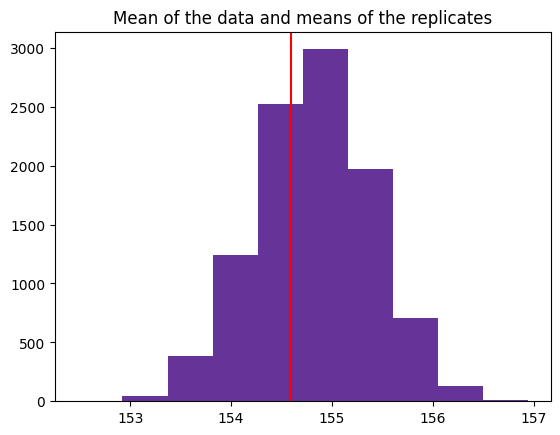

In [36]:
plt.hist(posterior_predictive_samples.mean(axis=1), color='rebeccapurple')
plt.axvline(dat_adults['height'].mean(), color='r')
plt.title("Mean of the data and means of the replicates")

# p-value
(posterior_predictive_samples.mean(axis=1) > dat_adults['height'].mean()).mean()

0.501

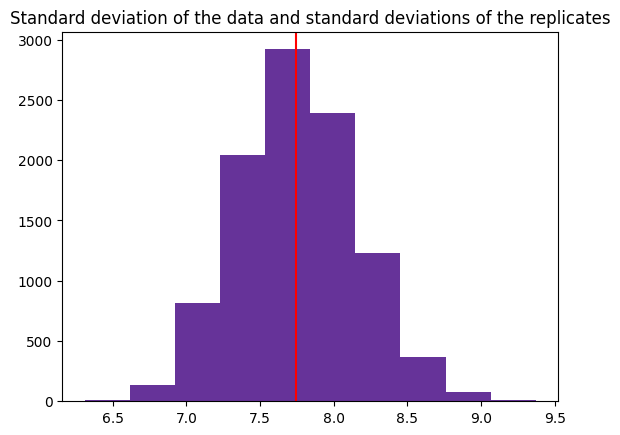

In [37]:
plt.hist(posterior_predictive_samples.std(axis=1), color='rebeccapurple')
plt.axvline(dat_adults['height'].std(), color='r')
plt.title("Standard deviation of the data and standard deviations of the replicates")

# p-value
(posterior_predictive_samples.std(axis=1) > dat_adults['height'].std()).mean()

0.0492

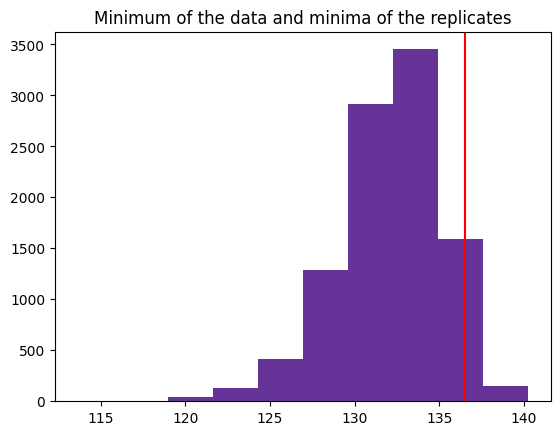

In [38]:
plt.hist(posterior_predictive_samples.min(axis=1), color='rebeccapurple')
plt.axvline(dat_adults['height'].min(), color='r')
plt.title("Minimum of the data and minima of the replicates")

# p-value
(posterior_predictive_samples.min(axis=1) > dat_adults['height'].min()).mean()

0.2794

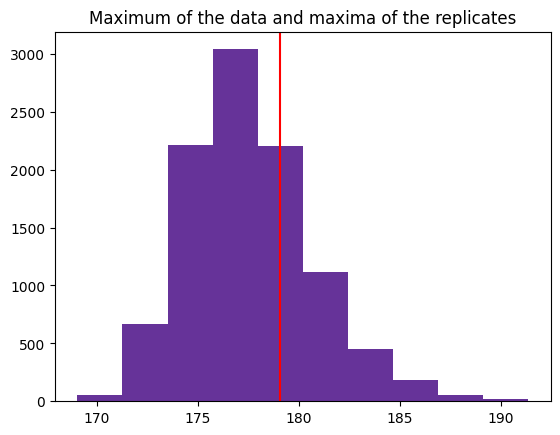

In [39]:
plt.hist(posterior_predictive_samples.max(axis=1), color='rebeccapurple')
plt.axvline(dat_adults['height'].max(), color='r')
plt.title("Maximum of the data and maxima of the replicates")

# p-value
(posterior_predictive_samples.max(axis=1) > dat_adults['height'].max()).mean()

Does this mean that the model is bad? That depends. The model will always be wrong in some sense, be *mis-specified*. But **whether or not the mis-specification should lead us to try other models will depend upon our specific interests.**

## How does the result change with other prior for $\mu$?

In [56]:
mu_list             = np.linspace(166.5, 167.1, 100)
sigma_list          = np.linspace(13.25, 15.75, 100)
mu_grid, sigma_grid = np.meshgrid(mu_list, sigma_list)

In [57]:
loglike = []

for i in range(len(mu_grid.ravel())):
    loglike.append(norm.logpdf(dat_adults['height'], mu_grid.ravel()[i], sigma_grid.ravel()[i]).sum())
    
loglike = np.array(loglike).reshape(mu_grid.shape)

In [58]:
logpost = loglike + norm.logpdf(mu_grid, 167, 0.1) + uniform.logpdf(sigma_grid, loc=0, scale=33)

Estimate the posterior

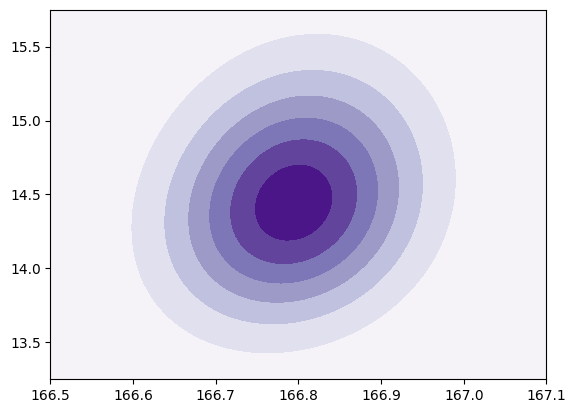

In [59]:
plt.contourf(mu_grid, sigma_grid, np.exp(logpost - logpost.max()), cmap='Purples')

Note that the estimate of $\sigma$ has changed a lot, even though we didn't change its prior. Once the model is certain that the mean is near 170--as the prior insists-- the model has to estimate $\sigma$ conditional on that fact. Thus the only way to explain heights far from 170 is increasing the estimate in $\sigma$.

### Generate a sample from the posterior

In [60]:
candidates = pd.DataFrame(np.c_[mu_grid.ravel(), sigma_grid.ravel()], columns=['mu', 'sigma'])
sample_ind = random.choices(range(candidates.shape[0]), weights=np.exp(logpost - logpost.max()).ravel(), k=10**4)
posterior_sample = candidates.iloc[sample_ind]
posterior_sample = posterior_sample.reset_index(drop=True)

<AxesSubplot:xlabel='mu', ylabel='sigma'>

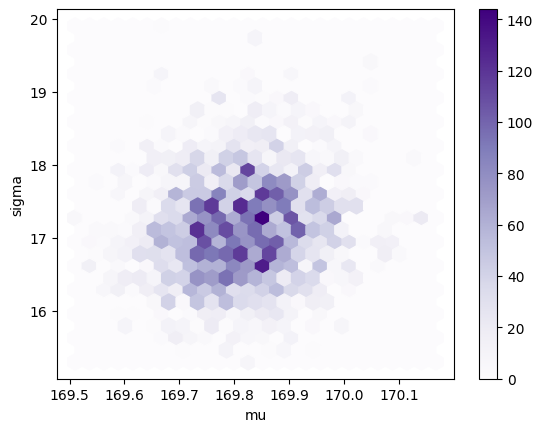

In [47]:
posterior_sample.iloc[sample_ind].plot.hexbin(x='mu', y='sigma', cmap='Purples', gridsize=25)

In [48]:
posterior_sample.describe()

,mu,sigma
count,10000.000000,10000.000000
mean,169.815108,17.128717
std,0.098886,0.660481
min,169.500000,15.101010
25%,169.752525,16.666667
50%,169.813131,17.121212
75%,169.883838,17.575758
max,170.237374,19.949495


In [49]:
az.hdi(posterior_sample.to_numpy(), hdi_prob=0.5)

/tmp/ipykernel_13127/1197683196.py:1: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  az.hdi(posterior_sample.to_numpy(), hdi_prob=0.5)


array([[169.72222222, 169.85353535],
       [ 16.51515152,  17.37373737]])

### Model checking

In [61]:
posterior_predictive_samples = []

for i in range(n_posterior):
     posterior_predictive_samples.append(
        norm.rvs(
            size=len(dat_adults)
            , loc=posterior_sample.iloc[i]['mu']
            , scale=posterior_sample.iloc[i]['sigma'])
        )

posterior_predictive_samples = np.array(posterior_predictive_samples)

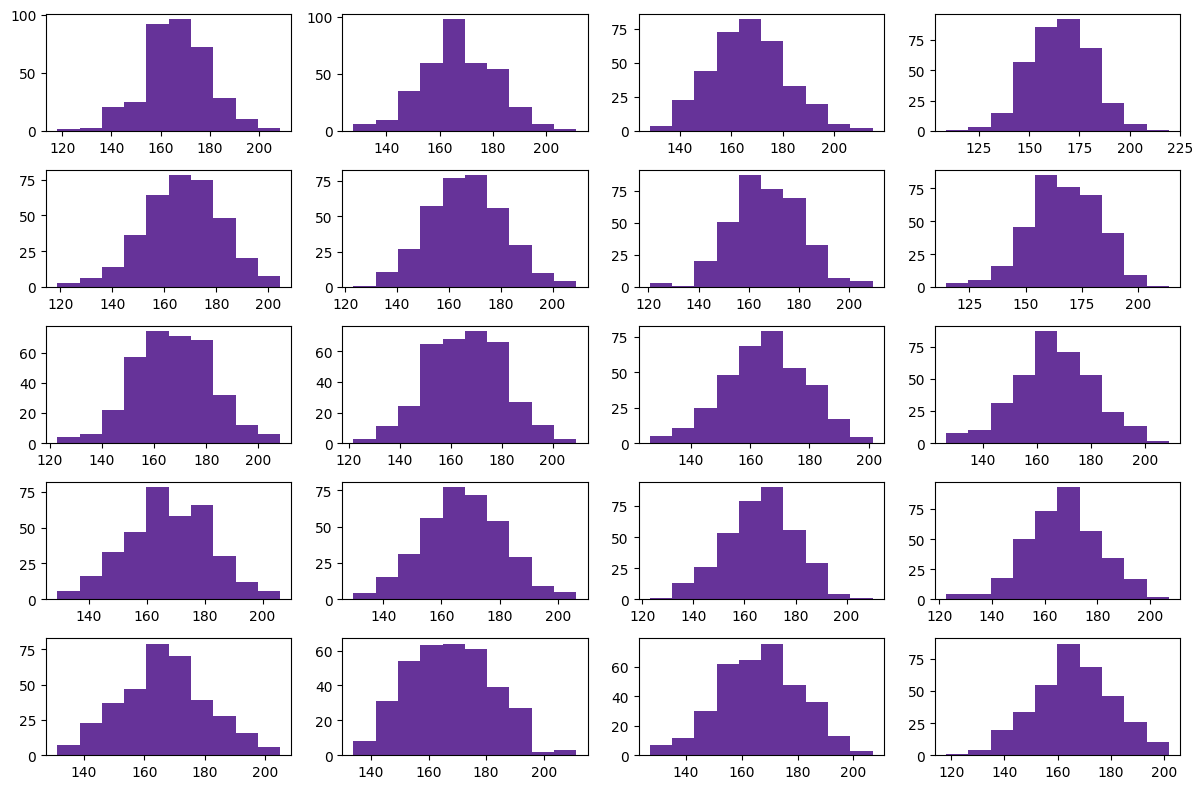

In [62]:
fig, axs = plt.subplots(figsize=(12, 8), ncols=4, nrows=5)

ind = 0
for j in range(5):
    for k in range(4):
        axs[j, k].hist(posterior_predictive_samples[ind], color='rebeccapurple')
        ind = ind + 1
        
fig.tight_layout()

Text(0.5, 1.0, 'Distribution of the measurements')

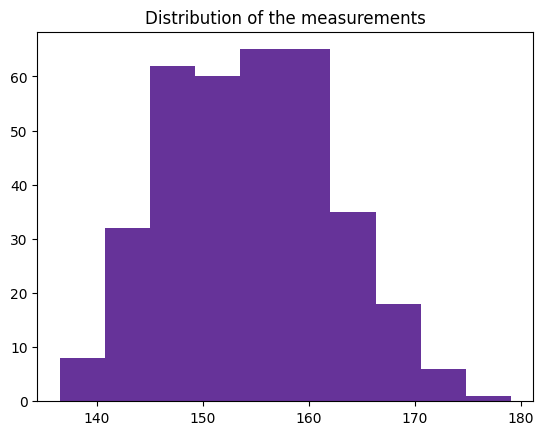

In [63]:
plt.hist(dat_adults['height'], color='rebeccapurple')
plt.title('Distribution of the measurements')

### Test quantities and p-values

1.0

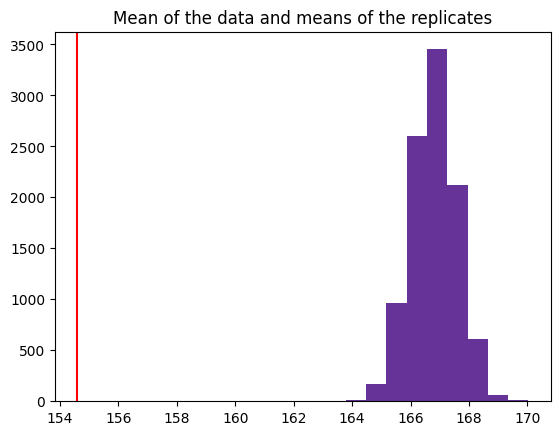

In [64]:
plt.hist(posterior_predictive_samples.mean(axis=1), color='rebeccapurple')
plt.axvline(dat_adults['height'].mean(), color='r')
plt.title("Mean of the data and means of the replicates")

# p-value
(posterior_predictive_samples.mean(axis=1) > dat_adults['height'].mean()).mean()

1.0

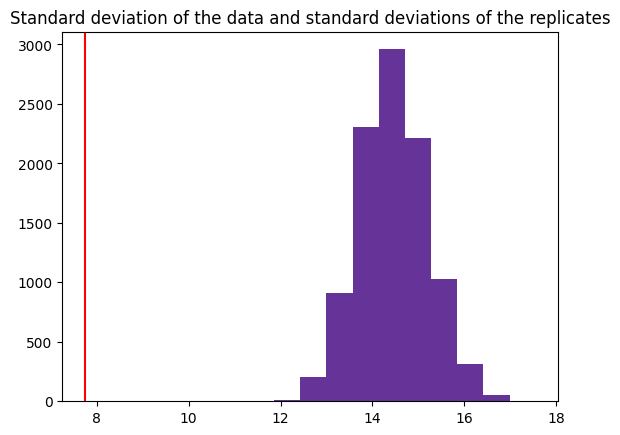

In [65]:
plt.hist(posterior_predictive_samples.std(axis=1), color='rebeccapurple')
plt.axvline(dat_adults['height'].std(), color='r')
plt.title("Standard deviation of the data and standard deviations of the replicates")

# p-value
(posterior_predictive_samples.std(axis=1) > dat_adults['height'].std()).mean()

0.0023

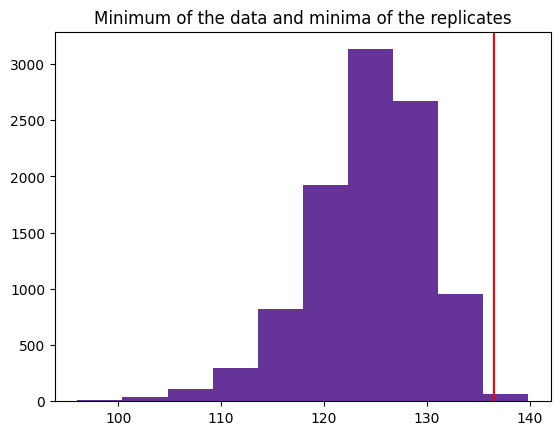

In [66]:
plt.hist(posterior_predictive_samples.min(axis=1), color='rebeccapurple')
plt.axvline(dat_adults['height'].min(), color='r')
plt.title("Minimum of the data and minima of the replicates")

# p-value
(posterior_predictive_samples.min(axis=1) > dat_adults['height'].min()).mean()